In [1]:
import matplotlib.pyplot as plt

from Utils.UtilsViz import *
from Utils.DataExtractor import DataExtractor

In [2]:
# Read the data from the database
db_extractor = DataExtractor()
db = "kdd_2014"
cols_to_select = ["donationid", "is_teacher_acct", 
                  "donation_to_project",
                  "donation_included_optional_support",
                  "donation_optional_support",
                  "donation_total", "dollar_amount",
                  "payment_method", 
                  "payment_included_acct_credit", 
                  "payment_included_campaign_gift_card",
                  "payment_included_web_purchased_gift_card",
                  "year", "month", "day"]
cols_to_select_str = ','.join(cols_to_select)
table_name = "donations"
query = "SELECT " + cols_to_select_str + " FROM " + table_name + " ;"
donations_data = db_extractor.read_db(db="kdd_2014", query=query, 
                                      host="localhost", user="root", pwd="root") 

How many unique donations do we have?

In [3]:
print("Number of unique donations :", donations_data["donationid"].unique().shape[0], 
      "\n\tin", donations_data.shape[0], "rows")

Number of unique donations : 3097989 
	in 3097989 rows


In [4]:
print("Total value of donations in millions :", donations_data["donation_total"].sum()/1e6)

Total value of donations in millions : 237.54421552


### Time Data Sanity Check

Do we have data from complete years in the dataset?

In [5]:
for year in np.sort(donations_data["year"].unique()):
    print("For year", year, " we have ", end="")
    print(donations_data[donations_data["year"]==year]["month"].unique().shape[0], end="")
    print(" months of data -->", end=" ")
    print(donations_data[donations_data["year"]==year]["month"].unique()) 

For year 2000  we have 1 months of data --> [3]
For year 2001  we have 12 months of data --> [12  1 11  3  6 10  2  7  8  5  4  9]
For year 2002  we have 12 months of data --> [11 12  1 10  7  9  4  2  6  8  5  3]
For year 2003  we have 12 months of data --> [11  6  7 12  8  9  2  4  3 10  1  5]
For year 2004  we have 12 months of data --> [ 6 11 12  9  4 10  3  5  8  1  2  7]
For year 2005  we have 12 months of data --> [12 10  6  9 11  1  4  5  7  8  2  3]
For year 2006  we have 12 months of data --> [11 12  9 10  3  2  8  4  5  7  1  6]
For year 2007  we have 12 months of data --> [12 11  1  2  8  3  4 10  6  7  5  9]
For year 2008  we have 12 months of data --> [ 2  4  3  1 11 12 10  9  6  7  5  8]
For year 2009  we have 12 months of data --> [ 8  5 12  9 10  4  2  3  7  1 11  6]
For year 2010  we have 12 months of data --> [11 12  7  9 10  4  3  2  6  1  8  5]
For year 2011  we have 12 months of data --> [ 8 11 10  3 12  2  1  7  9  6  5  4]
For year 2012  we have 12 months of dat

In [6]:
# Sadly we're going to ignore two years of data once again. 
# Let's start from 2003 to maintain consistency with the project data
years_to_ignore = [2000, 2001, 2002, 2014]
donations_data = donations_data[~donations_data["year"].isin(years_to_ignore)] 

Quick look at how donation_optional_support and donation_to_project variables behave

                           donation_optional_support  donation_to_project
donation_optional_support                       1.00                 0.87
donation_to_project                             0.87                 1.00


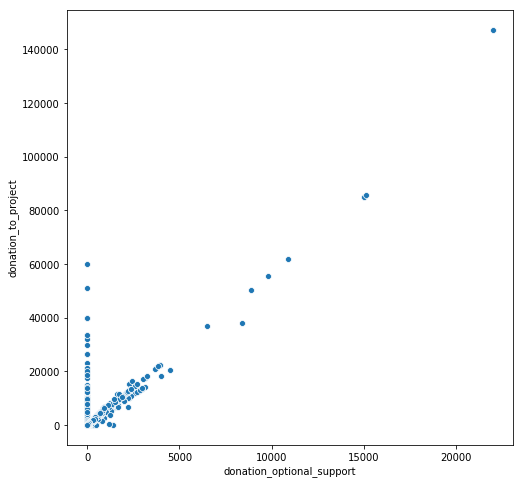

In [7]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
corr = np.round(donations_data[["donation_optional_support", 
                               "donation_to_project"]].corr(), 2)
print(corr) 
g = sns.scatterplot(x="donation_optional_support", y="donation_to_project", data=donations_data, ax=ax)

##### Donation trends over time. 

Any hot time windows where we see donations happen the most? 

In [8]:
donations_year_group = donations_data[["donationid", "year"]].groupby(by="year", as_index=False).count()
# What's the distribution of total monetary value like? 
cols = ["donation_total", "year", "month"]
total_amt_year_group = donations_data[cols].groupby(by=["year", "month"], as_index=False).sum()

month_group = donations_data[["donationid", "month"]].groupby(by="month", as_index=False).count()

month_year_group = \
    donations_data[["year", "month", "donationid"]].\
        groupby(by=["year", "month"], as_index=False).count()
month_year_group["scaled_count"] = \
    (month_year_group["donationid"] / month_year_group["donationid"].max()) * 1000 


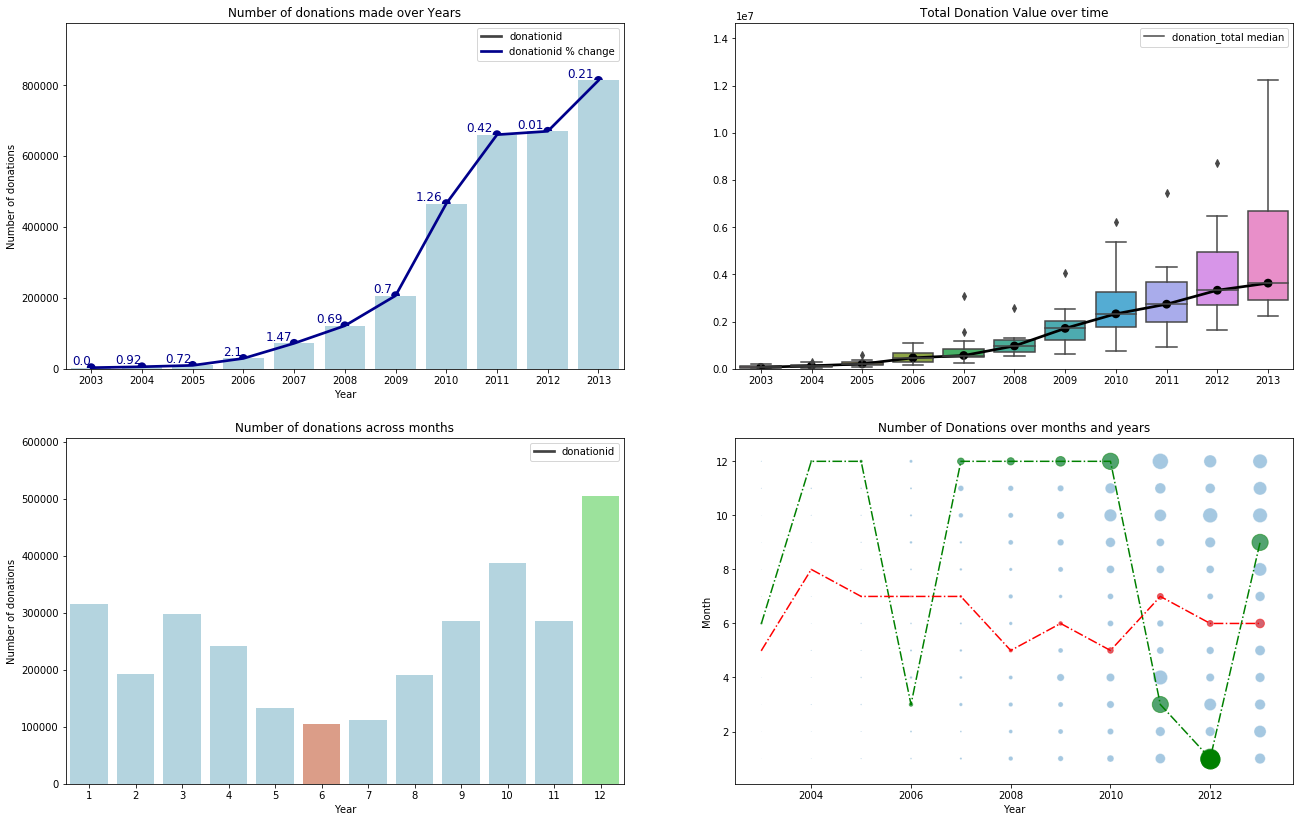

In [11]:
f, ax = plt.subplots(2, 2, figsize=(22, 14))
plot_bar_timegraph(x="year", y="donationid", data=donations_year_group, ax=ax[0][0], 
                   title="Number of donations made over Years", xlabel="Year", ylabel="Number of donations")
plot_box_timegraph(x="year", y="donation_total", data=total_amt_year_group, agg_rule="median", ax=ax[0][1],
                   title="Total Donation Value over time")
plot_bar_timegraph(x="month", y="donationid", data=month_group, ax=ax[1][0],
                   highlight_max_min=True, point_plot=False, annot=False,
                   title="Number of donations across months", xlabel="Year", ylabel="Number of donations")
plot_bubblehist(x="year", y="month", s="scaled_count", data=month_year_group, 
                title="Number of Donations over months and years", xlabel="Year", ylabel="Month", ax=ax[1][1]) 


### Payment Methods

How have payment methods behaved over time?

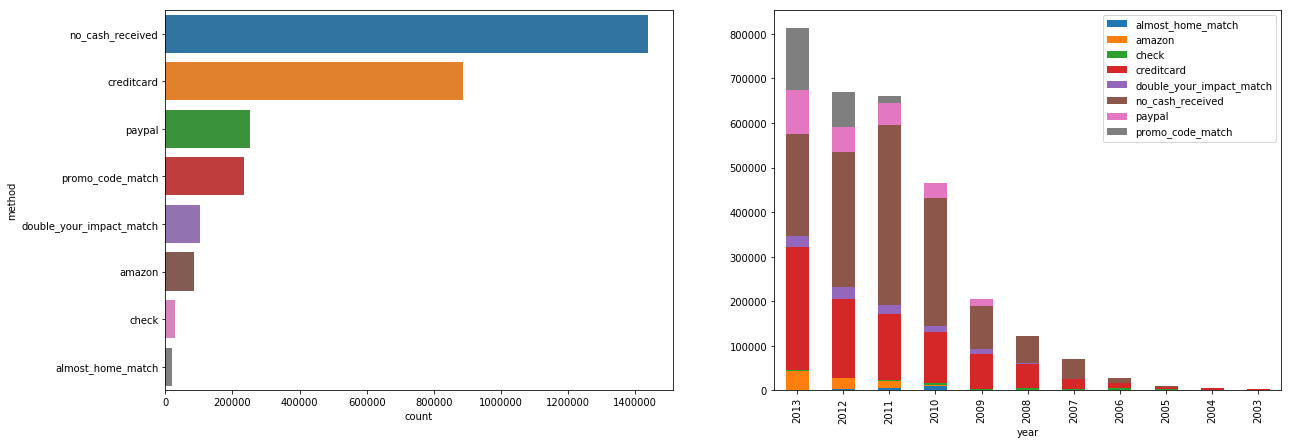

In [10]:
# What was the most popular payment method
payment_df = donations_data[["payment_method", "year", "month", "day"]]
payment_methods_df = payment_df["payment_method"].value_counts().to_frame().reset_index(drop=False)
payment_methods_df.columns = ["method", "count"]

cols = ["payment_method", "year"]
payment_methods_year_group = group_and_sort(dataframe=payment_df[cols],  dummycol="payment_method", groupbycol="year")
payment_methods_year_group.sort_index(inplace=True, ascending=False)

fig, ax = plt.subplots(1,2, figsize=(20,7))
g = sns.barplot(x="count", y="method", data=payment_methods_df, ax=ax[0])
g = payment_methods_year_group.plot(kind="bar", stacked=True, ax=ax[1])

###### What all did the payments include?

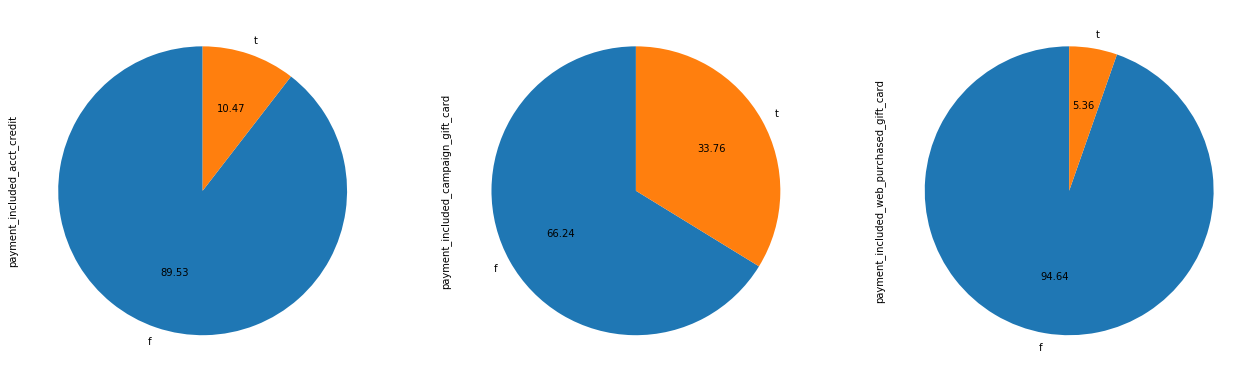

In [11]:
f, ax = plt.subplots(1, 3, figsize=(22, 7))
plot_pie(data=donations_data, col_name="payment_included_acct_credit", ax=ax[0])   
plot_pie(data=donations_data, col_name="payment_included_campaign_gift_card", ax=ax[1])   
plot_pie(data=donations_data, col_name="payment_included_web_purchased_gift_card", ax=ax[2])   

### Contributions of Teachers

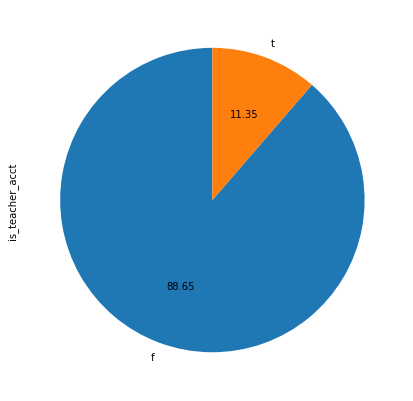

In [12]:
# Are some donors also teachers? 
teacher_donor_df = donations_data[["is_teacher_acct", "year", "month", "day"]]
f, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_pie(data=teacher_donor_df, col_name="is_teacher_acct", ax=ax)

##### Over time, did the participation of teachers/non-teachers behave consistently as donors?

In [13]:
# Over time, did the number of participating teachers increase?
teacher_donor_subset = teacher_donor_df[teacher_donor_df["is_teacher_acct"] == "t"]
tds_year_group = teacher_donor_subset[["is_teacher_acct", "year"]].groupby(by="year", as_index=False).count()

# How about non teachers?
nonteacher_donor_subset = teacher_donor_df[teacher_donor_df["is_teacher_acct"] == "f"]
ntds_year_group = nonteacher_donor_subset[["is_teacher_acct", "year"]].groupby(by="year", as_index=False).count()

month_group = \
    teacher_donor_df[["is_teacher_acct", "month"]].groupby(by="month", as_index=False).count()

month_year_group = \
    teacher_donor_df[["year", "month", "is_teacher_acct"]].\
        groupby(by=["year", "month"], as_index=False).count()
month_year_group["scaled_count"] = \
    (month_year_group["is_teacher_acct"] / month_year_group["is_teacher_acct"].max()) * 1000 

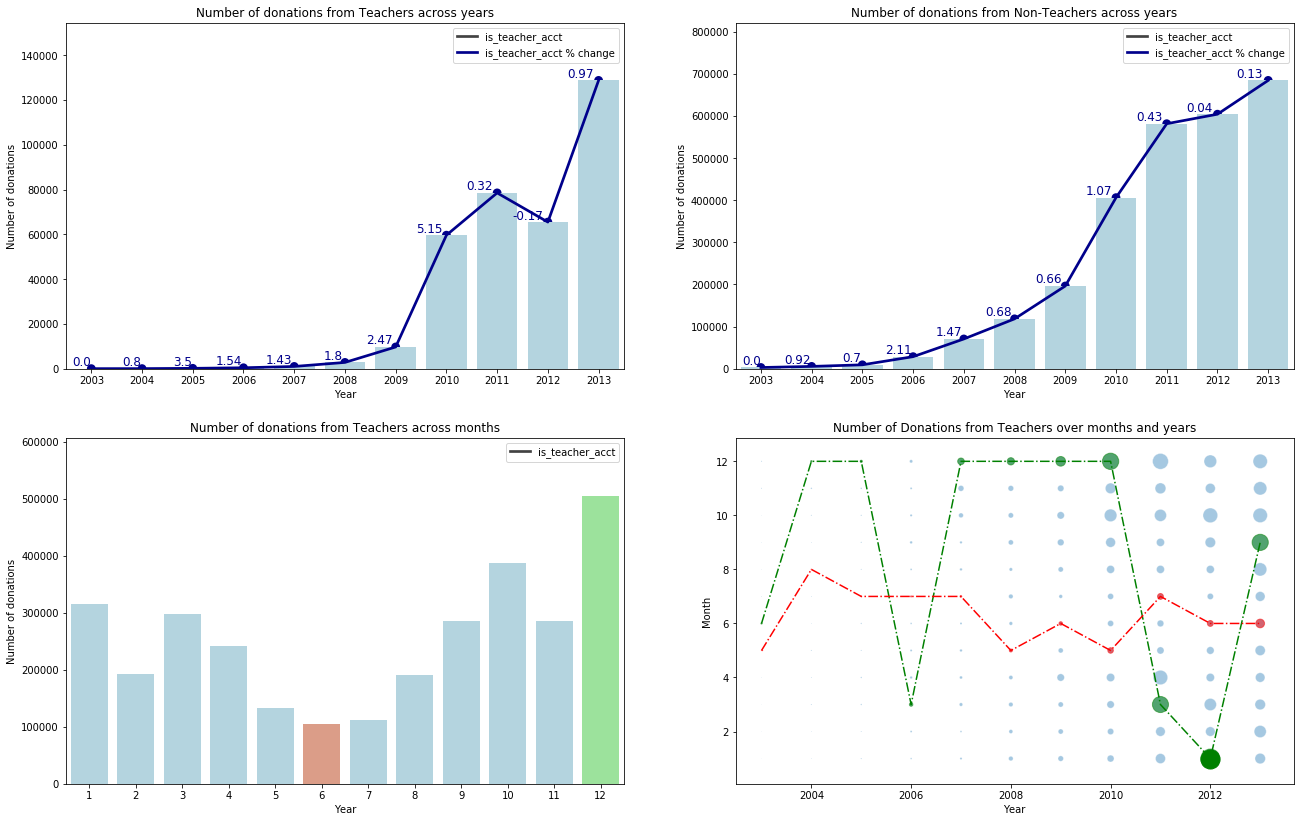

In [15]:
f, ax = plt.subplots(2, 2, figsize=(22, 14))
plot_bar_timegraph(x="year", y="is_teacher_acct", data=tds_year_group, ax=ax[0][0],
                   title="Number of donations from Teachers across years", 
                   xlabel="Year", ylabel="Number of donations")
plot_bar_timegraph(x="year", y="is_teacher_acct", data=ntds_year_group, ax=ax[0][1],
                   title="Number of donations from Non-Teachers across years", 
                   xlabel="Year", ylabel="Number of donations")
plot_bar_timegraph(x="month", y="is_teacher_acct", data=month_group, ax=ax[1][0],
                   highlight_max_min=True, point_plot=False, annot=False,
                   title="Number of donations from Teachers across months", 
                   xlabel="Year", ylabel="Number of donations")
plot_bubblehist(x="year", y="month", s="scaled_count", data=month_year_group, 
                title="Number of Donations from Teachers over months and years", 
                xlabel="Year", ylabel="Month", ax=ax[1][1])